In [1]:
import os
os.environ['J_NOTEBOOK'] = '1'

from preprocess.preprocess import *
import PARAMETERS
import sys
sys.path.append('./preprocess/')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from confusion_matrix_pretty_print import print_confusion_matrix
from pathlib import Path

%matplotlib inline


PARAMETERS.PREPROCESS_OPTIMIZATION = True

PARAMETERS.LBP_METHOD = 'riu'
PARAMETERS.METHOD = 'get_pyramid_dataset'
PARAMETERS.INTERPOLATION_ALGORITHM = 'lanczos'
PARAMETERS.BALANCE = False
PARAMETERS.N_SCALES = 5
PARAMETERS.GRAY_INTENSITY = True
PARAMETERS.X2SCALE = True
PARAMETERS.FILE_EXTENSION = PARAMETERS.update_file_extension(PARAMETERS)
PARAMETERS.PLOT = False
PARAMETERS.DATASET = 'DRIVE'
TRAIN_SIZE = 14 if PARAMETERS.DATASET != 'CHASE' else 20
TOTAL_SIZE = 20 if PARAMETERS.DATASET != 'CHASE' else 28

pd.DataFrame({k: getattr(PARAMETERS, k) for k in VALID_PARAMETERS.keys()}, index=['Parameters']).head()

,LBP_METHOD,METHOD,INTERPOLATION_ALGORITHM,BALANCE,N_SCALES,GRAY_INTENSITY,X2SCALE
Parameters,riu,get_pyramid_dataset,lanczos,False,5,True,True


In [2]:
# Get CV folds

import pandas as pd
import numpy as np

preprocess = Preprocess(
    lbp_radius=1,
    lbp_method=PARAMETERS.LBP_METHOD,
    height={'DRIVE': 608, 'CHASE': 960, 'STARE': 608}[PARAMETERS.DATASET],
    width={'DRIVE': 576, 'CHASE': 1024, 'STARE': 704}[PARAMETERS.DATASET],
    balance=PARAMETERS.BALANCE
)
masks_path = f'../dataset/{PARAMETERS.DATASET}/training/mask/'
masks = sorted(os.listdir(masks_path))[:TRAIN_SIZE]

n_pixels = {}
for i, mask_path in enumerate(masks):
    mask = preprocess.read_img(masks_path + mask_path)
    n_pixels[i] = np.sum(mask > 100)
    
pixel_ref = {}

for k, v in n_pixels.items():
    upper = np.sum(np.array(list(n_pixels.values()))[:k+1])
    pixel_ref[k] = (upper - n_pixels[k], upper)

print(pixel_ref)
cv_folds = {}

for i, j in enumerate(range(0, TRAIN_SIZE, round(TRAIN_SIZE/5))):
    cv_folds[i] = (pixel_ref[j][0], pixel_ref[min(j+round(TRAIN_SIZE/5)-1, TRAIN_SIZE-1)][1])
    

{0: (0, 225600), 1: (225600, 453286), 2: (453286, 681473), 3: (681473, 909199), 4: (909199, 1136561), 5: (1136561, 1361653), 6: (1361653, 1589479), 7: (1589479, 1816806), 8: (1816806, 2044115), 9: (2044115, 2271374), 10: (2271374, 2499075), 11: (2499075, 2724019), 12: (2724019, 2951757), 13: (2951757, 3178299)}


In [3]:
import pandas as pd

df_train = pd.DataFrame()
df_test = pd.DataFrame()

#for conf in ['_blue', '_blue_lbp_gb', '_green', '_green_lbp_gb']:
for conf in ['_green_lbp_g']:

    df_train_riu = pd.read_pickle(f'../DB/{PARAMETERS.DATASET}/extra_features/preprocess_optimization{conf}/train_train_riu_get_pyramid_dataset_lanczos_balance-False_scales-5_x2-True_gray-intensity-True.pkl', compression='gzip')
    df_test_riu = pd.read_pickle(f'../DB/{PARAMETERS.DATASET}/extra_features/preprocess_optimization{conf}/train_test_riu_get_pyramid_dataset_lanczos_balance-False_scales-5_x2-True_gray-intensity-True.pkl', compression='gzip')

    df_train_riu.columns = [c + '_riu' if c not in ['Original', 'label'] else c for c in df_train_riu.columns]
    df_test_riu.columns = [c + '_riu' if c not in ['Original', 'label'] else c for c in df_test_riu.columns]

    if df_train.shape[0] == 0:
        y_train = df_train_riu['label']
        y_test = df_test_riu['label']
    df_train_riu = df_train_riu.drop(['label'], axis=1)
    df_test_riu = df_test_riu.drop(['label'], axis=1)


    df_train_var = pd.read_pickle(f'../DB/{PARAMETERS.DATASET}/extra_features/preprocess_optimization{conf}/train_train_var_get_pyramid_dataset_lanczos_balance-False_scales-5_x2-True_gray-intensity-True.pkl', compression='gzip')
    df_test_var = pd.read_pickle(f'../DB/{PARAMETERS.DATASET}/extra_features/preprocess_optimization{conf}/train_test_var_get_pyramid_dataset_lanczos_balance-False_scales-5_x2-True_gray-intensity-True.pkl', compression='gzip')

    df_train_var.columns = [c + '_var' if c not in ['Original', 'label'] else c for c in df_train_var.columns]
    df_test_var.columns = [c + '_var' if c not in ['Original', 'label'] else c for c in df_test_var.columns]

    df_train_var = df_train_var.drop(['Original', 'label'], axis=1)
    df_test_var = df_test_var.drop(['Original', 'label'], axis=1)

    df_train_temp = pd.concat([df_train_riu, df_train_var], axis=1)
    df_test_temp = pd.concat([df_test_riu, df_test_var], axis=1)
    df_train_temp.columns = [c + conf for c in df_train_temp.columns]
    df_test_temp.columns = [c + conf for c in df_test_temp.columns]

    if df_train.shape[0] > 0:
        df_train_temp.index = df_train.index
        df_test_temp.index = df_test.index
    df_train = pd.concat([df_train, df_train_temp], axis=1)
    df_test = pd.concat([df_test, df_test_temp], axis=1)
    
display(df_train)
display(df_test)

,Original_green_lbp_g,1:1_riu_green_lbp_g,1:2_riu_green_lbp_g,1:4_riu_green_lbp_g,1:8_riu_green_lbp_g,2:1_1_riu_green_lbp_g,2:1_2_riu_green_lbp_g,2:1_3_riu_green_lbp_g,2:1_4_riu_green_lbp_g,1:1_var_green_lbp_g,1:2_var_green_lbp_g,1:4_var_green_lbp_g,1:8_var_green_lbp_g,2:1_1_var_green_lbp_g,2:1_2_var_green_lbp_g,2:1_3_var_green_lbp_g,2:1_4_var_green_lbp_g
0,2.0,35.0,8.0,8.0,8.0,9.0,9.0,16.0,8.0,18.049300,2691.523366,2816.494723,2134.944450,11.493193,9.448573,17.435591,15.057359
1,2.0,34.0,8.0,8.0,8.0,9.0,0.0,8.0,34.0,37.541454,2691.523366,2816.494723,2134.944450,8.447647,6.260227,12.963602,10.813002
2,2.0,34.0,8.0,8.0,8.0,9.0,1.0,27.0,35.0,64.923163,2728.380278,2755.308975,2134.944450,5.959122,3.510395,6.007235,3.377165
3,2.0,4.0,8.0,8.0,8.0,9.0,9.0,34.0,34.0,90.715861,2728.380278,2755.308975,2134.944450,2.464777,1.080965,3.878203,5.703805
4,2.0,27.0,8.0,8.0,8.0,9.0,1.0,34.0,34.0,107.285915,2746.841934,2755.308975,2134.944450,0.593639,0.816103,7.692123,7.171601
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226537,3.0,16.0,8.0,35.0,8.0,8.0,8.0,35.0,35.0,831.932087,731.033413,1344.736959,1822.496624,360.764386,342.393769,88.019078,66.964242
226538,3.0,4.0,8.0,35.0,8.0,8.0,8.0,35.0,35.0,649.954725,731.033413,1344.736959,1822.496624,549.212369,677.907122,53.993511,35.221283
226539,3.0,8.0,16.0,35.0,8.0,8.0,4.0,8.0,16.0,389.032615,717.984941,1432.625419,1822.496624,271.868208,57.896099,19.599378,6.102433
226540,2.0,27.0,16.0,35.0,8.0,2.0,1.0,8.0,34.0,133.587029,717.984941,1432.625419,1822.496624,10.479992,3.561978,3.355944,0.889331


,Original_green_lbp_g,1:1_riu_green_lbp_g,1:2_riu_green_lbp_g,1:4_riu_green_lbp_g,1:8_riu_green_lbp_g,2:1_1_riu_green_lbp_g,2:1_2_riu_green_lbp_g,2:1_3_riu_green_lbp_g,2:1_4_riu_green_lbp_g,1:1_var_green_lbp_g,1:2_var_green_lbp_g,1:4_var_green_lbp_g,1:8_var_green_lbp_g,2:1_1_var_green_lbp_g,2:1_2_var_green_lbp_g,2:1_3_var_green_lbp_g,2:1_4_var_green_lbp_g
0,3.0,4.0,35.0,8.0,8.0,1.0,9.0,34.0,35.0,6.954297,101.574460,1150.728568,898.272755,2.698548,3.608622,2.223276,1.876082
1,3.0,4.0,35.0,8.0,8.0,1.0,9.0,35.0,34.0,3.466316,101.574460,1150.728568,898.272755,3.586646,4.724168,2.273066,2.642552
2,3.0,2.0,8.0,8.0,8.0,1.0,9.0,35.0,35.0,1.762458,131.991801,1150.728568,898.272755,4.532919,5.282802,3.033254,3.152247
3,3.0,9.0,8.0,8.0,8.0,1.0,1.0,27.0,27.0,0.932945,131.991801,1150.728568,898.272755,4.669947,4.378025,4.205974,5.434448
4,3.0,4.0,31.0,4.0,8.0,1.0,1.0,27.0,27.0,3.466316,164.566767,979.405645,898.272755,6.681710,7.579463,3.215237,2.928628
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226969,2.0,6.0,35.0,4.0,8.0,26.0,4.0,6.0,8.0,6.983381,421.057276,683.573134,761.754830,2.494801,3.856601,0.628950,1.626841
226970,2.0,34.0,35.0,4.0,8.0,8.0,16.0,35.0,35.0,24.654873,421.057276,683.573134,761.754830,7.897857,7.952501,1.014407,0.565263
226971,2.0,35.0,4.0,8.0,4.0,2.0,27.0,3.0,1.0,12.825603,256.615122,651.463164,843.281428,2.065825,2.649209,0.937004,0.721403
226972,2.0,27.0,4.0,8.0,4.0,35.0,35.0,9.0,1.0,34.017418,256.615122,651.463164,843.281428,2.073544,1.962023,2.500048,2.147529


In [4]:
# CV

from main import init_clf_and_fit
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

def cross_validate_features(features, verbose=True):
    f1_list = []
    acc_list = []
    if isinstance(features['y_train'], pd.Series):
        features['y_train'] = features['y_train'].to_frame()
    for k, v in cv_folds.items():
        df_train_temp = pd.concat(
            [features['x_train'].iloc[cv_folds[0][0]:v[0], :],
             features['x_train'].iloc[v[1]:cv_folds[4][1], :]], axis=0)
        y_train_temp = pd.concat(
            [features['y_train'].iloc[cv_folds[0][0]:v[0], :],
             features['y_train'].iloc[v[1]:cv_folds[4][1], :]], axis=0)
        clf = init_clf_and_fit(df_train_temp, y_train_temp.values.ravel(), lgb='Num')
        y_predicted = clf.predict(features['x_train'].iloc[v[0]:v[1], :])
        acc = accuracy_score(features['y_train'].iloc[v[0]:v[1], :], y_predicted)
        acc_list.append(acc)
        f1 = f1_score(features['y_train'].iloc[v[0]:v[1], :], y_predicted)
        f1_list.append(f1)
        mat = confusion_matrix(features['y_train'].iloc[v[0]:v[1], :], y_predicted).ravel()
        if verbose:
            print('Accuracy score: ' + str(acc) + '\n')
            print('F1 score: ' + str(f1) + '\n')
            print('Confusion matrix:\n')
            print_confusion_matrix(features['y_train'].iloc[v[0]:v[1], :].values.ravel(), y_predicted.ravel())
            print(f'Sensivity: {int(mat[3]) / (int(mat[3]) + int(mat[2]))}')
            print(f'Specificity: {int(mat[0]) / (int(mat[0]) + int(mat[1]))}')
            print('-------------------------------------')

    return {'acc': np.mean(acc_list), 'f1': np.mean(f1_list)}


cross_validate_features({'x_train': df_train, 'y_train':y_train})

Accuracy score: 0.9248789020254654

F1 score: 0.6668228648040038

Confusion matrix:

     t/p    0.0   1.0 
      0.0 579051 26258 
      1.0 24935 51229 
Sensivity: 0.6726143584895752
Specificity: 0.9566205029166921
-------------------------------------
Accuracy score: 0.9189332235584698

F1 score: 0.6436787551373846

Confusion matrix:

     t/p    0.0   1.0 
      0.0 575236  7569 
      1.0 47571 49804 
Sensivity: 0.5114659820282413
Specificity: 0.9870128087439195
-------------------------------------
Accuracy score: 0.9312093567114359

F1 score: 0.7005873836871879

Confusion matrix:

     t/p    0.0   1.0 
      0.0 580590 12854 
      1.0 34093 54925 
Sensivity: 0.6170100429126694
Specificity: 0.9783399950121663
-------------------------------------
Accuracy score: 0.9381118510848591

F1 score: 0.669587750294464

Confusion matrix:

     t/p    0.0   1.0 
      0.0 595190 11984 
      1.0 30094 42636 
Sensivity: 0.5862230166368761
Specificity: 0.9802626594682908
-------------------

{'acc': 0.9253787138716083, 'f1': 0.6648389786611129}

In [5]:
import pickle
from os import listdir

PATH = fr'/home/fer/Drive/Estudios/Master-IA/TFM/dataset/{PARAMETERS.DATASET}/training/images'
MASK_PATH = fr'/home/fer/Drive/Estudios/Master-IA/TFM/dataset/{PARAMETERS.DATASET}/training/mask'
LABELS_PATH = fr'/home/fer/Drive/Estudios/Master-IA/TFM/dataset/{PARAMETERS.DATASET}/training/1st_manual'

def load_images():
    paths = [f"{PATH}/{path}" for path in sorted(listdir(PATH))][:TRAIN_SIZE]
    return [np.asarray(Image.open(path).convert('RGB'))[:, :, 1] for path in paths]

def load_masks():
    paths = [f"{MASK_PATH}/{path}" for path in sorted(listdir(MASK_PATH))][:TRAIN_SIZE]
    return [np.asarray(Image.open(path).convert('L')) > 100 for path in paths]

IMAGES = load_images()
MASKS = load_masks()

with open(r'/home/fer/Drive/Estudios/Master-IA/TFM/lbp-pyramid/convolution/outputs/16544931165874937_200_iterations_corrected/population.pkl', 'rb') as f:
    kernels = pickle.load(f)
    
population, fitness = kernels['population'], kernels['fitness']
individual = population[np.argmax(fitness), :]
n_kernels = 6
k_size = (3, 5, 7)

features = [pd.DataFrame()]*TRAIN_SIZE
count = 0
for j, ks in enumerate(k_size):
    k_len = int(ks**2)
    features = [
        pd.concat([feat_df, pd.DataFrame(np.array(
            [cv2.filter2D(img, -1, individual[(count + i*k_len):(count + (i + 1) * k_len)].reshape((ks, ks)))[mask]
             for i in range(n_kernels // len(k_size))]
        ).T, columns=np.arange(j * (n_kernels // len(k_size)), (j + 1) * (n_kernels // len(k_size))))], axis=1)
        for img, mask, feat_df in zip(IMAGES, MASKS, features)
    ]
    count += k_len * (n_kernels // len(k_size))
    
conv_features = pd.concat(features, ignore_index=True)

conv_features.index = df_train.index

In [6]:
cross_validate_features({
    'x_train': pd.concat([df_train, conv_features], axis=1),
    'y_train': y_train,
})

Accuracy score: 0.9367854632538634

F1 score: 0.715351424927812

Confusion matrix:

     t/p    0.0   1.0 
      0.0 584263 21046 
      1.0 22033 54131 
Sensivity: 0.7107163489312536
Specificity: 0.9652309812013369
-------------------------------------
Accuracy score: 0.9250610132611956

F1 score: 0.6799568018283878

Confusion matrix:

     t/p    0.0   1.0 
      0.0 575061  7744 
      1.0 43228 54147 
Sensivity: 0.5560667522464698
Specificity: 0.9867125367833152
-------------------------------------
Accuracy score: 0.9386456681837231

F1 score: 0.7394885833385181

Confusion matrix:

     t/p    0.0   1.0 
      0.0 581161 12283 
      1.0 29589 59429 
Sensivity: 0.6676065514839695
Specificity: 0.9793021750999252
-------------------------------------
Accuracy score: 0.9427154421800725

F1 score: 0.7090392947855969

Confusion matrix:

     t/p    0.0   1.0 
      0.0 593500 13674 
      1.0 25274 47456 
Sensivity: 0.6524955314175719
Specificity: 0.9774792728278879
-------------------

{'acc': 0.9303193372225614, 'f1': 0.6994488782735854}

In [7]:
def load_images_test():
    paths = [f"{PATH}/{path}" for path in sorted(listdir(PATH))][TRAIN_SIZE:]
    return [np.asarray(Image.open(path).convert('RGB'))[:, :, 1] for path in paths]

def load_masks_test():
    paths = [f"{MASK_PATH}/{path}" for path in sorted(listdir(MASK_PATH))][TRAIN_SIZE:]
    return [np.asarray(Image.open(path).convert('L')) > 100 for path in paths]

IMAGES_test = load_images_test()
MASKS_test = load_masks_test()

features_test = [pd.DataFrame()]*TRAIN_SIZE
count = 0
for j, ks in enumerate(k_size):
    k_len = int(ks**2)
    features_test = [
        pd.concat([feat_df, pd.DataFrame(np.array(
            [cv2.filter2D(img, -1, individual[(count + i*k_len):(count + (i + 1) * k_len)].reshape((ks, ks)))[mask]
             for i in range(n_kernels // len(k_size))]
        ).T, columns=np.arange(j * (n_kernels // len(k_size)), (j + 1) * (n_kernels // len(k_size))))], axis=1)
        for img, mask, feat_df in zip(IMAGES_test, MASKS_test, features_test)
    ]
    count += k_len * (n_kernels // len(k_size))
    
conv_features_test = pd.concat(features_test, ignore_index=True)
conv_features_test.index = df_test.index

Columns: Index([ 'Original_green_lbp_g',   '1:1_riu_green_lbp_g',
         '1:2_riu_green_lbp_g',   '1:4_riu_green_lbp_g',
         '1:8_riu_green_lbp_g', '2:1_1_riu_green_lbp_g',
       '2:1_2_riu_green_lbp_g', '2:1_3_riu_green_lbp_g',
       '2:1_4_riu_green_lbp_g',   '1:1_var_green_lbp_g',
         '1:2_var_green_lbp_g',   '1:4_var_green_lbp_g',
         '1:8_var_green_lbp_g', '2:1_1_var_green_lbp_g',
       '2:1_2_var_green_lbp_g', '2:1_3_var_green_lbp_g',
       '2:1_4_var_green_lbp_g',                       0,
                             1,                       2,
                             3,                       4,
                             5],
      dtype='object')


/home/fer/anaconda3/envs/TFM/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


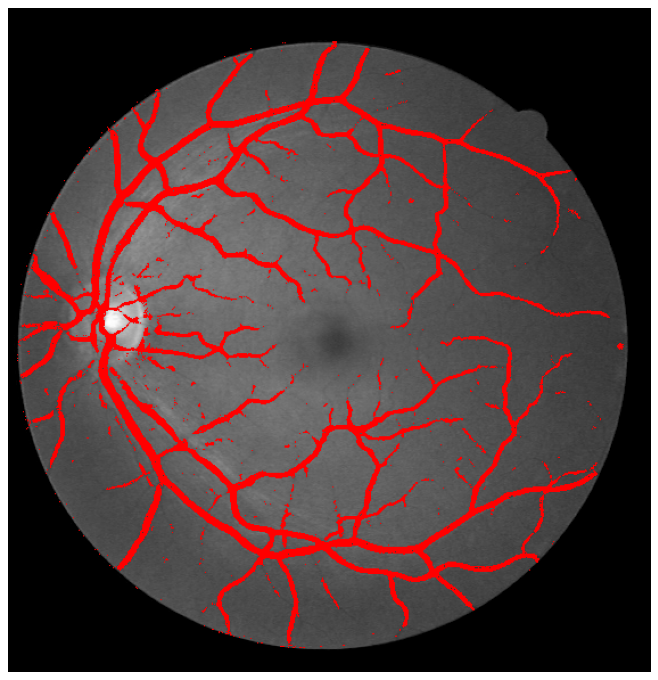

Accuracy score: 0.9406776364985283

F1 score: 0.7582182582765808

Confusion matrix:

     t/p    0.0   1.0 
      0.0 1155114 32431 
      1.0 48408 126754 
Sensivity: 0.7236386887566938
Specificity: 0.9726907190885398


(0.941, 0.758, 1155114, 32431, 48408, 126754)

In [8]:
features = {
    'x_train': pd.concat([df_train, conv_features], axis=1).copy(),
    'x_test': pd.concat([df_test, conv_features_test], axis=1).copy(),
    'y_train': y_train.copy(),
    'y_test': y_test.copy()
}

features_copy = {
    'x_train': pd.concat([df_train, conv_features], axis=1).copy(),
    'x_test': pd.concat([df_test, conv_features_test], axis=1).copy(),
    'y_train': y_train.copy(),
    'y_test': y_test.copy()
}

from main import main
PARAMETERS.PLOT = True
PARAMETERS.DATASET = 'DRIVE'


main(lgb='Num', features=features, plot_once=True, recurrence=True)

In [9]:
PARAMETERS.DATASET = 'DRIVE_TEST'
y_train_drive = y_train.copy()
y_test_drive = y_test.copy()
features_drive = features_copy

In [10]:
import pandas as pd

df_train = pd.DataFrame()
df_test = pd.DataFrame()

#for conf in ['_blue', '_blue_lbp_gb', '_green', '_green_lbp_gb']:
for conf in ['_green_lbp_g']:

    df_train_riu = pd.read_pickle(f'../DB/{PARAMETERS.DATASET}/extra_features/preprocess_optimization{conf}/train_train_riu_get_pyramid_dataset_lanczos_balance-False_scales-5_x2-True_gray-intensity-True.pkl', compression='gzip')
    df_test_riu = pd.read_pickle(f'../DB/{PARAMETERS.DATASET}/extra_features/preprocess_optimization{conf}/train_test_riu_get_pyramid_dataset_lanczos_balance-False_scales-5_x2-True_gray-intensity-True.pkl', compression='gzip')

    df_train_riu.columns = [c + '_riu' if c not in ['Original', 'label'] else c for c in df_train_riu.columns]
    df_test_riu.columns = [c + '_riu' if c not in ['Original', 'label'] else c for c in df_test_riu.columns]

    if df_train.shape[0] == 0:
        y_train = df_train_riu['label']
        y_test = df_test_riu['label']
    df_train_riu = df_train_riu.drop(['label'], axis=1)
    df_test_riu = df_test_riu.drop(['label'], axis=1)


    df_train_var = pd.read_pickle(f'../DB/{PARAMETERS.DATASET}/extra_features/preprocess_optimization{conf}/train_train_var_get_pyramid_dataset_lanczos_balance-False_scales-5_x2-True_gray-intensity-True.pkl', compression='gzip')
    df_test_var = pd.read_pickle(f'../DB/{PARAMETERS.DATASET}/extra_features/preprocess_optimization{conf}/train_test_var_get_pyramid_dataset_lanczos_balance-False_scales-5_x2-True_gray-intensity-True.pkl', compression='gzip')

    df_train_var.columns = [c + '_var' if c not in ['Original', 'label'] else c for c in df_train_var.columns]
    df_test_var.columns = [c + '_var' if c not in ['Original', 'label'] else c for c in df_test_var.columns]

    df_train_var = df_train_var.drop(['Original', 'label'], axis=1)
    df_test_var = df_test_var.drop(['Original', 'label'], axis=1)

    df_train_temp = pd.concat([df_train_riu, df_train_var], axis=1)
    df_test_temp = pd.concat([df_test_riu, df_test_var], axis=1)
    df_train_temp.columns = [c + conf for c in df_train_temp.columns]
    df_test_temp.columns = [c + conf for c in df_test_temp.columns]

    if df_train.shape[0] > 0:
        df_train_temp.index = df_train.index
        df_test_temp.index = df_test.index
    df_train = pd.concat([df_train, df_train_temp], axis=1)
    df_test = pd.concat([df_test, df_test_temp], axis=1)
    
display(df_train)
display(df_test)

,Original_green_lbp_g,1:1_riu_green_lbp_g,1:2_riu_green_lbp_g,1:4_riu_green_lbp_g,1:8_riu_green_lbp_g,2:1_1_riu_green_lbp_g,2:1_2_riu_green_lbp_g,2:1_3_riu_green_lbp_g,2:1_4_riu_green_lbp_g,1:1_var_green_lbp_g,1:2_var_green_lbp_g,1:4_var_green_lbp_g,1:8_var_green_lbp_g,2:1_1_var_green_lbp_g,2:1_2_var_green_lbp_g,2:1_3_var_green_lbp_g,2:1_4_var_green_lbp_g
0,3.0,8.0,8.0,16.0,8.0,34.0,34.0,8.0,8.0,2412.839731,2260.287041,1628.289511,1452.766323,236.364049,270.689456,1428.518243,1427.723386
1,3.0,8.0,8.0,16.0,8.0,8.0,4.0,8.0,4.0,2417.664813,2260.287041,1628.289511,1452.766323,292.090002,299.699957,1422.337502,1404.027448
2,3.0,8.0,8.0,8.0,8.0,34.0,35.0,16.0,16.0,2445.781271,2346.018019,1732.990877,1653.789823,257.407380,254.855021,1319.242162,1347.731902
3,3.0,8.0,8.0,8.0,8.0,35.0,35.0,8.0,8.0,2378.589474,2346.018019,1732.990877,1653.789823,267.226317,276.051308,1420.013856,1463.577857
4,3.0,8.0,8.0,8.0,8.0,27.0,8.0,8.0,8.0,2403.803554,2480.772418,1732.990877,1653.789823,280.586895,292.230168,1448.723056,1427.030728
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225849,3.0,35.0,8.0,8.0,4.0,16.0,8.0,35.0,35.0,2653.462145,2382.978553,2149.720456,2178.363242,1628.739870,1627.566517,239.835871,227.663726
225850,3.0,35.0,27.0,8.0,8.0,8.0,8.0,34.0,35.0,2182.837551,1827.137054,1956.927395,1868.928465,1508.219018,1149.027800,191.053263,151.690615
225851,3.0,35.0,27.0,8.0,8.0,8.0,8.0,27.0,27.0,1606.897676,1827.137054,1956.927395,1868.928465,804.482664,692.697434,115.657668,68.500656
225852,3.0,35.0,34.0,8.0,8.0,8.0,8.0,27.0,27.0,855.035391,1443.453118,1956.927395,1868.928465,653.728241,434.582934,37.336876,13.875395


,Original_green_lbp_g,1:1_riu_green_lbp_g,1:2_riu_green_lbp_g,1:4_riu_green_lbp_g,1:8_riu_green_lbp_g,2:1_1_riu_green_lbp_g,2:1_2_riu_green_lbp_g,2:1_3_riu_green_lbp_g,2:1_4_riu_green_lbp_g,1:1_var_green_lbp_g,1:2_var_green_lbp_g,1:4_var_green_lbp_g,1:8_var_green_lbp_g,2:1_1_var_green_lbp_g,2:1_2_var_green_lbp_g,2:1_3_var_green_lbp_g,2:1_4_var_green_lbp_g
0,3.0,10.0,34.0,8.0,8.0,1.0,9.0,34.0,27.0,7.496810,459.332222,832.439788,626.807029,0.909436,0.432945,0.621367,0.549444
1,3.0,0.0,34.0,8.0,8.0,1.0,1.0,34.0,27.0,3.671188,459.332222,832.439788,626.807029,0.330961,0.915560,0.686735,1.712629
2,3.0,13.0,35.0,8.0,8.0,8.0,2.0,27.0,27.0,3.378680,456.857565,832.439788,626.807029,1.501727,0.828095,1.955434,1.778535
3,3.0,15.0,34.0,8.0,8.0,15.0,1.0,1.0,27.0,3.282478,467.283718,830.990361,626.807029,2.264023,3.790993,0.537613,2.681010
4,3.0,4.0,34.0,8.0,8.0,1.0,1.0,16.0,27.0,13.045079,467.283718,830.990361,626.807029,4.551388,5.990077,8.571568,10.234149
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227518,2.0,35.0,35.0,34.0,8.0,16.0,16.0,16.0,16.0,0.984393,866.756378,1719.068578,2016.794502,26.338059,25.663188,14.671635,14.671635
227519,2.0,35.0,35.0,34.0,8.0,16.0,16.0,16.0,16.0,0.984393,866.756378,1719.068578,2016.794502,27.814346,28.430506,14.671635,14.671635
227520,2.0,35.0,35.0,34.0,8.0,16.0,16.0,16.0,16.0,4.289534,956.828152,1719.068578,2016.794502,28.430506,29.101355,14.671635,14.671635
227521,2.0,35.0,35.0,34.0,8.0,16.0,16.0,16.0,16.0,3.497347,956.828152,1719.068578,2016.794502,31.469042,32.135869,14.671635,14.671635


In [11]:
import pickle
from os import listdir

PATH = fr'/home/fer/Drive/Estudios/Master-IA/TFM/dataset/{PARAMETERS.DATASET}/training/images'
MASK_PATH = fr'/home/fer/Drive/Estudios/Master-IA/TFM/dataset/{PARAMETERS.DATASET}/training/mask'
LABELS_PATH = fr'/home/fer/Drive/Estudios/Master-IA/TFM/dataset/{PARAMETERS.DATASET}/training/1st_manual'

def load_images():
    paths = [f"{PATH}/{path}" for path in sorted(listdir(PATH))][:TRAIN_SIZE]
    return [np.asarray(Image.open(path).convert('RGB'))[:, :, 1] for path in paths]

def load_masks():
    paths = [f"{MASK_PATH}/{path}" for path in sorted(listdir(MASK_PATH))][:TRAIN_SIZE]
    return [np.asarray(Image.open(path).convert('L')) > 100 for path in paths]

IMAGES = load_images()
MASKS = load_masks()

with open(r'/home/fer/Drive/Estudios/Master-IA/TFM/lbp-pyramid/convolution/outputs/16544931165874937_200_iterations_corrected/population.pkl', 'rb') as f:
    kernels = pickle.load(f)
    
population, fitness = kernels['population'], kernels['fitness']
individual = population[np.argmax(fitness), :]
n_kernels = 6
k_size = (3, 5, 7)

features = [pd.DataFrame()]*TRAIN_SIZE
count = 0
for j, ks in enumerate(k_size):
    k_len = int(ks**2)
    features = [
        pd.concat([feat_df, pd.DataFrame(np.array(
            [cv2.filter2D(img, -1, individual[(count + i*k_len):(count + (i + 1) * k_len)].reshape((ks, ks)))[mask]
             for i in range(n_kernels // len(k_size))]
        ).T, columns=np.arange(j * (n_kernels // len(k_size)), (j + 1) * (n_kernels // len(k_size))))], axis=1)
        for img, mask, feat_df in zip(IMAGES, MASKS, features)
    ]
    count += k_len * (n_kernels // len(k_size))
    
conv_features = pd.concat(features, ignore_index=True)

conv_features.index = df_train.index

def load_images_test():
    paths = [f"{PATH}/{path}" for path in sorted(listdir(PATH))][TRAIN_SIZE:]
    return [np.asarray(Image.open(path).convert('RGB'))[:, :, 1] for path in paths]

def load_masks_test():
    paths = [f"{MASK_PATH}/{path}" for path in sorted(listdir(MASK_PATH))][TRAIN_SIZE:]
    return [np.asarray(Image.open(path).convert('L')) > 100 for path in paths]

IMAGES_test = load_images_test()
MASKS_test = load_masks_test()

features_test = [pd.DataFrame()]*TRAIN_SIZE
count = 0
for j, ks in enumerate(k_size):
    k_len = int(ks**2)
    features_test = [
        pd.concat([feat_df, pd.DataFrame(np.array(
            [cv2.filter2D(img, -1, individual[(count + i*k_len):(count + (i + 1) * k_len)].reshape((ks, ks)))[mask]
             for i in range(n_kernels // len(k_size))]
        ).T, columns=np.arange(j * (n_kernels // len(k_size)), (j + 1) * (n_kernels // len(k_size))))], axis=1)
        for img, mask, feat_df in zip(IMAGES_test, MASKS_test, features_test)
    ]
    count += k_len * (n_kernels // len(k_size))
    
conv_features_test = pd.concat(features_test, ignore_index=True)
conv_features_test.index = df_test.index

In [12]:
df_train = pd.concat([df_train, conv_features], axis=1)
df_test = pd.concat([df_test, conv_features_test], axis=1)

In [13]:
full_features = {
    'x_train': pd.concat([features_drive['x_train'], features_drive['x_test']], axis=0, ignore_index=True),
    'x_test': pd.concat([df_train, df_test], axis=0, ignore_index=True),
    'y_train': pd.concat([y_train_drive, y_test_drive], axis=0, ignore_index=True),
    'y_test': pd.concat([y_train, y_test], axis=0, ignore_index=True),
}

Columns: Index([ 'Original_green_lbp_g',   '1:1_riu_green_lbp_g',
         '1:2_riu_green_lbp_g',   '1:4_riu_green_lbp_g',
         '1:8_riu_green_lbp_g', '2:1_1_riu_green_lbp_g',
       '2:1_2_riu_green_lbp_g', '2:1_3_riu_green_lbp_g',
       '2:1_4_riu_green_lbp_g',   '1:1_var_green_lbp_g',
         '1:2_var_green_lbp_g',   '1:4_var_green_lbp_g',
         '1:8_var_green_lbp_g', '2:1_1_var_green_lbp_g',
       '2:1_2_var_green_lbp_g', '2:1_3_var_green_lbp_g',
       '2:1_4_var_green_lbp_g',                       0,
                             1,                       2,
                             3,                       4,
                             5],
      dtype='object')


/home/fer/anaconda3/envs/TFM/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


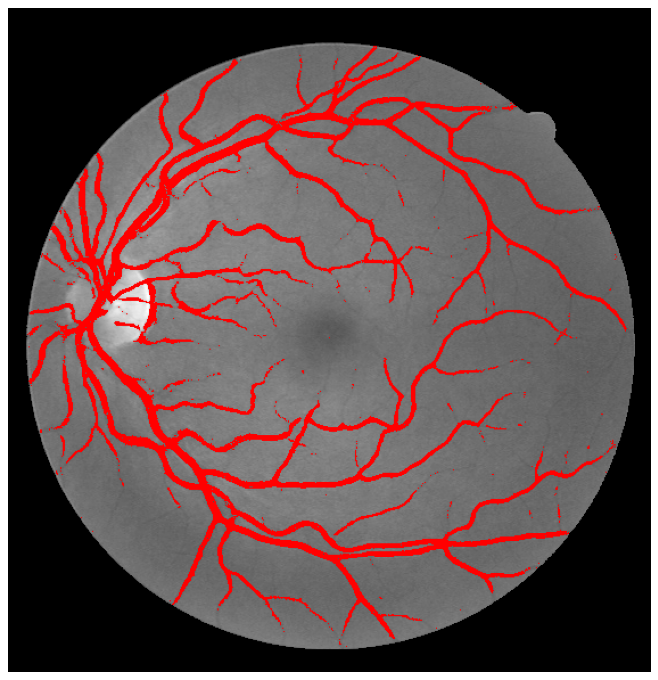

Accuracy score: 0.9448146521605864

F1 score: 0.7631757871713087

Confusion matrix:

     t/p    0.0   1.0 
      0.0 3884179 76315 
      1.0 174124 403525 
Sensivity: 0.6985643530933144
Specificity: 0.9807309391202209


(0.945, 0.763, 3884179, 76315, 174124, 403525)

In [14]:
main(lgb='Num', features=full_features, plot_once=True, recurrence=True)